In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon April 29 13:25:11 2020

@author: rfuchs
"""

import os 

%matplotlib inline
import pandas as pd
from copy import deepcopy
from gower import gower_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder 

from MIAMI import MIAMI
from init_params import dim_reduce_init
from data_preprocessing import compute_nj

from shapely.geometry import Polygon as polygon

import autograd.numpy as np

import colorcet as cc
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:

res_folder = 'MIAMI/Results/structure/'


        




    
dtypes_dict = {'continuous': float, 'categorical': str, 'ordinal': int,\
              'bernoulli': int, 'binomial': int}
#===========================================#
# Importing data
#===========================================#

inf_nb = 1E12

sub_design = "bivariate"

# acceptance_rate =
le_dict = {}

import json
with open(res_folder + "optimal_run.json") as f:
    synthetic = json.load(f)
with open(res_folder + "real_structures.json") as f:
    real = json.load(f)
with open(res_folder + "random_dataset_1000_designs.json") as f:
    rand = json.load(f)
    
    
# from https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

brace_dict = {    
    "NONE": 0,
    "H": 1,
    "Z": 2,
    "IZ": 3,
    "ZH": 4,
    "IZH": 5,
    "K": 6,
    "X": 7,
    "XH": 8,
}

brace_dict_inv = dict(zip(brace_dict.values(), brace_dict.keys()))

N_BRACES = len(brace_dict)
def encode(d, max_layers, one_hot=True, native=False):
    basics = [d["legs"], d["total_height"], d["radius_bottom"], d["radius_top"], d["n_layers"]]
    
    # fill design's braces according to max_layers with dummies ("NONE")
    braces = d["connection_types"]
    if native:
        braces = np.array([b for b in braces] + ["NONE"] * (max_layers - 1 - len(braces)))
    else:
        braces = np.array([brace_dict[b] for b in braces] + [brace_dict["NONE"]] * (max_layers - 1 - len(braces)))
        if one_hot:
            braces = get_one_hot(braces, N_BRACES)
    
    # fill design's layer_heights according to max_layers with dummies
    layer_heights = d["layer_heights"]
    layer_heights = np.array(layer_heights + [d["total_height"]] * (max_layers - 2 - len(layer_heights))) / d["total_height"]
    
    # return a flat encoding
    return np.array([*basics, *braces.flatten(), *layer_heights])

def get_cols(d, max_layers, one_hot=True, native=False):
    
    # fill design's braces according to max_layers with dummies ("NONE")
    braces = d["connection_types"]
    if native:
        braces = np.array([b for b in braces] + ["NONE"] * (max_layers - 1 - len(braces)))
    else:
        braces = np.array([brace_dict[b] for b in braces] + [brace_dict["NONE"]] * (max_layers - 1 - len(braces)))
        if one_hot:
            braces = get_one_hot(braces, N_BRACES)
    
    # fill design's layer_heights according to max_layers with dummies
    layer_heights = d["layer_heights"]
    layer_heights = np.array(layer_heights + [d["total_height"]] * (max_layers - 2 - len(layer_heights))) / d["total_height"]
    transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"] + ["brace" + str(i) for i in range(len(braces.flatten()))] + ["layer_height" + str(i) for i in range(len(layer_heights))]
    
    # return a flat encoding
    return transformed_columns, ["brace" + str(i) for i in range(len(braces.flatten()))]

# max_layers = max([d["n_layers"] for d in real] + [d["n_layers"] for d in synthetic] + [d["n_layers"] for d in rand])
max_layers = max([d["n_layers"] for d in real])

encodings_real = [encode(d, max_layers, one_hot=False, native=True) for d in real]
transformed_columns, brace_cols = get_cols(real[0], max_layers, one_hot=False)

# encodings_rand = [encode(d, max_layers, one_hot=False, native=True) for d in rand]
# transformed_columns, brace_cols = get_cols(rand[0], max_layers, one_hot=False)

# encodings_synthetic = [encode(d, max_layers, one_hot=False, native=True) for d in synthetic]
# transformed_columns, brace_cols = get_cols(synthetic[0], max_layers, one_hot=False)

real = pd.DataFrame(encodings_real, columns=transformed_columns)
# synthetic = pd.DataFrame(encodings_synthetic, columns=transformed_columns)
# rand = pd.DataFrame(encodings_rand, columns=transformed_columns)

# Assuming the "real" and "synthetic" dataframes have different number of rows
label_real = ["real"] * len(real)
# label_synthetic = ["synthetic (GA)"] * len(synthetic)
# label_rand = ["random"] * len(rand)

real['label'] = label_real  # add the label column to the "real" dataframe
# synthetic['label'] = label_synthetic  # add the label column to the "synthetic" dataframe
# rand['label'] = label_rand  # add the label column to the "synthetic" dataframe



In [3]:
# Concatenate the two dataframes together and reindex
# train_original = pd.concat([real, synthetic, rand], axis=0, ignore_index=True)

# synth_original = pd.concat([synthetic], axis=0, ignore_index=True)

train_original = pd.concat([real], axis=0, ignore_index=True)

nominal_features = brace_cols
ordinal_features = ["n_layers", "legs"]
BERNOULLI = ["legs"]

continuous_features = list(set(transformed_columns) - set(nominal_features) - set(ordinal_features))

train_original[ordinal_features] = train_original[ordinal_features].astype("int")
train_original[continuous_features] = train_original[continuous_features].astype("float")

# synth_original[ordinal_features] = synth_original[ordinal_features].astype("int")
# synth_original[continuous_features] = synth_original[continuous_features].astype("float")

train = train_original.drop("label", axis=1)

# synth = synth_original.drop("label", axis=1)





train = train.infer_objects()
# synth = synth.infer_objects()
print(train.dtypes)


numobs = len(train)
print("Running with", numobs, "observations!!!!")

legs               int64
total_height     float64
radius_bottom    float64
radius_top       float64
n_layers           int64
brace0            object
brace1            object
brace2            object
brace3            object
brace4            object
layer_height0    float64
layer_height1    float64
layer_height2    float64
layer_height3    float64
dtype: object
Running with 100 observations!!!!


In [4]:
#*****************************************************************
# Formating the data
#*****************************************************************
# 
unique_counts = train.nunique()


var_distrib = []     
var_transform_only = []     
# Encode categorical datas
for colname, dtype, unique in zip(train.columns, train.dtypes, train.nunique()):
    if unique < 2:
        print("Dropped", colname, "because of 0 var")
        train.drop(colname, axis=1, inplace=True)
        continue

    if (dtype==int or dtype == "object") and unique==2:
        #bool
        
        var_distrib.append('bernoulli')
        if colname in BERNOULLI:
            var_transform_only.append('bernoulli')
        else:
            var_transform_only.append('categorical')
            
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype==int and unique > 2:
        # ordinal
        
        var_distrib.append('ordinal')
        var_transform_only.append('ordinal')
        
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype == "object":
        var_distrib.append('categorical')
        var_transform_only.append('categorical')
        
        le = LabelEncoder()
        # Convert them into numerical values               
        train[colname] = le.fit_transform(train[colname]) 
        le_dict[colname] = deepcopy(le)
    elif dtype == float:
        var_distrib.append('continuous')
        var_transform_only.append('continuous')
        
    
var_distrib = np.array(var_distrib)



nj, nj_bin, nj_ord, nj_categ = compute_nj(train, var_distrib)

nb_cont = np.sum(var_distrib == 'continuous')     

p = train.shape[1]
        
# Feature category (cf)
dtype = {train.columns[j]: dtypes_dict[var_transform_only[j]] for j in range(p)}

train_famd = train.astype(dtype, copy=True)
numobs = len(train)

# authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)
authorized_ranges = None


In [5]:
print(var_transform_only)
print(var_distrib)

['bernoulli', 'continuous', 'continuous', 'continuous', 'ordinal', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'continuous', 'continuous', 'continuous', 'continuous']
['bernoulli' 'continuous' 'continuous' 'continuous' 'ordinal' 'bernoulli'
 'bernoulli' 'bernoulli' 'bernoulli' 'bernoulli' 'continuous' 'continuous'
 'continuous' 'continuous']


In [6]:
sub_design = "none"


In [7]:
#*****************************************************************
# Sampling rules
#*****************************************************************    
# authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)


In [8]:
print(train.dtypes) 
print(train_famd.dtypes)

legs               int64
total_height     float64
radius_bottom    float64
radius_top       float64
n_layers           int64
brace0             int64
brace1             int64
brace2             int64
brace3             int64
brace4             int64
layer_height0    float64
layer_height1    float64
layer_height2    float64
layer_height3    float64
dtype: object
legs               int64
total_height     float64
radius_bottom    float64
radius_top       float64
n_layers           int64
brace0            object
brace1            object
brace2            object
brace3            object
brace4            object
layer_height0    float64
layer_height1    float64
layer_height2    float64
layer_height3    float64
dtype: object


In [9]:
#===========================================#
# Model Hyper-parameters
#===========================================#

n_clusters = 3
r = np.array([2, 1])
k = [n_clusters]

seed = 1
init_seed = 2
    
# !!! Changed eps
eps = 1E-05
it = 50
maxstep = 100
nb_pobs = 100

#*****************************************************************
# Run MIAMI
#*****************************************************************

print("Initialize dimensionality reduction")    
init, transformed_famd_data  = dim_reduce_init(train_famd, n_clusters, k, r, nj, var_distrib, seed = 2023,\
                                use_famd=True)

print("Computing distance matrix")
# # Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 

distances = pdist(transformed_famd_data)

dm = squareform(distances)


Initialize dimensionality reduction
[2.62521247 1.89107569]
(100, 2)
(6, 6)
Computing distance matrix


In [10]:
print(var_distrib)
print(train.columns)
print(nj)

['bernoulli' 'continuous' 'continuous' 'continuous' 'ordinal' 'bernoulli'
 'bernoulli' 'bernoulli' 'bernoulli' 'bernoulli' 'continuous' 'continuous'
 'continuous' 'continuous']
Index(['legs', 'total_height', 'radius_bottom', 'radius_top', 'n_layers',
       'brace0', 'brace1', 'brace2', 'brace3', 'brace4', 'layer_height0',
       'layer_height1', 'layer_height2', 'layer_height3'],
      dtype='object')
[ 1. inf inf inf  5.  1.  1.  1.  1.  1. inf inf inf inf]


In [11]:
print("Training")
out = MIAMI(train, n_clusters, r, k, init, var_distrib, nj, authorized_ranges, nb_pobs, it=it,\
                eps=eps, maxstep=maxstep, seed=seed, perform_selec = True, dm = dm, max_patience = 0)
print('MIAMI has kept one observation over', round(1 / out['share_kept_pseudo_obs']),\
        'observations generated')
    
acceptance_rate = out['share_kept_pseudo_obs']
print(acceptance_rate)
pred = pd.DataFrame(out['y_all'], columns = train.columns) 

Training
Iteration 0


/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:206: RuntimeWarning: One of the binomial optimisations has failed
  warnings.warn('One of the binomial optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:206: RuntimeWarning: One of the binomial optimisations has failed
  warnings.warn('One of the binomial optimisations has failed', RuntimeWarning)


Likelyhood [-1076.2743179695042]
silhouette [-1]
Iteration 1
Likelyhood [-1076.2743179695042, -1066.8548529201248]
silhouette [-1, 0.6976310388647029]
Iteration 2


/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:206: RuntimeWarning: One of the binomial optimisations has failed
  warnings.warn('One of the binomial optimisations has failed', RuntimeWarning)


Likelyhood [-1076.2743179695042, -1066.8548529201248, -1059.4698709998447]
silhouette [-1, 0.6976310388647029, 0.6976310388647029]
Iteration 3
Likelyhood [-1076.2743179695042, -1066.8548529201248, -1059.4698709998447, -1078.0829923227413]
silhouette [-1, 0.6976310388647029, 0.6976310388647029, 0.6976310388647029]
MIAMI has kept one observation over 1 observations generated
0.9900990099009901


In [12]:
import re

#================================================================
# Inverse transform the datasets
#================================================================
pred_trans = pred.copy()
for j, colname in enumerate(train.columns):
    if colname in le_dict.keys():
        pred_trans[colname] = le_dict[colname].inverse_transform(pred[colname].astype(int))
    
pred_post = pred_trans.copy()    
layer_height_cols = pred_post.filter(like='layer_height').columns.tolist()

# Define a function to apply to each row
def replace_layer_height(row):
    # Find the first index of NONE in braces
    none_index = row[['brace0', 'brace1', 'brace2', 'brace3', 'brace4']].eq('NONE').idxmax(axis=0)
    
    last_digit = int(re.findall(r'\d+', none_index)[-1])
    
    # Get the number of layers from the n_layers column
    n_layers = row['n_layers']
    # Set the layer_height columns to 1.0 for all rows after the nth row
    row['layer_height{}'.format(last_digit-1):] = 1.0
    
    # Return the modified row
    return row

# Apply the function to each row of the DataFrame
pred_post = pred_post.apply(replace_layer_height, axis=1)

    
    
print("Saved to", res_folder + 'preds.csv')
# Store the predictions
pred_trans.to_csv(res_folder + 'preds.csv', index = False)
#break

Saved to MIAMI/Results/structure/preds.csv


In [13]:
pred_post

,legs,total_height,radius_bottom,radius_top,n_layers,brace0,brace1,brace2,brace3,brace4,layer_height0,layer_height1,layer_height2,layer_height3
0,4,67.770944,14.050093,12.355813,4,X,X,X,NONE,NONE,0.443229,0.753239,1.000000,1.0
1,4,68.621160,15.001522,8.938072,4,X,X,X,NONE,NONE,0.233282,0.886633,1.000000,1.0
2,4,62.434380,15.664372,6.629603,4,X,X,X,NONE,NONE,0.500372,0.660597,1.000000,1.0
3,4,46.099890,15.252549,10.120285,4,X,X,NONE,NONE,NONE,0.643426,1.000000,1.000000,1.0
4,4,82.248997,5.455855,7.521377,5,X,X,X,X,NONE,0.316281,0.475041,0.705818,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,38.668758,23.103958,8.694536,4,X,X,X,NONE,NONE,0.560958,0.780611,1.000000,1.0
96,4,69.034918,13.506265,8.530413,5,X,X,X,X,NONE,0.228700,0.461570,0.587851,1.0
97,3,63.518971,17.028580,11.382502,4,X,X,X,NONE,NONE,0.445056,0.797158,1.000000,1.0
98,4,85.286501,12.415466,11.694057,5,X,X,X,X,NONE,0.109249,0.710333,0.750394,1.0


In [14]:
train_original

,legs,total_height,radius_bottom,radius_top,n_layers,brace0,brace1,brace2,brace3,brace4,layer_height0,layer_height1,layer_height2,layer_height3,label
0,4,22.0,16.968,15.554,2,X,NONE,NONE,NONE,NONE,1.000000,1.000000,1.000000,1.000000,real
1,3,77.0,21.362,11.761,3,X,X,NONE,NONE,NONE,0.545455,1.000000,1.000000,1.000000,real
2,4,32.9,20.704,6.640,3,X,X,NONE,NONE,NONE,0.545593,1.000000,1.000000,1.000000,real
3,3,50.0,16.166,8.706,3,X,X,NONE,NONE,NONE,0.482000,1.000000,1.000000,1.000000,real
4,3,51.0,19.029,9.336,3,X,X,NONE,NONE,NONE,0.549020,1.000000,1.000000,1.000000,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,44.5,19.796,7.777,5,X,X,X,X,NONE,0.325843,0.595506,0.820225,1.000000,real
96,4,43.5,18.382,7.777,5,X,X,X,X,NONE,0.321839,0.593103,0.816092,1.000000,real
97,4,50.3,18.382,7.777,5,X,X,X,X,NONE,0.310139,0.574553,0.805169,1.000000,real
98,4,52.0,18.382,7.777,5,X,X,X,X,NONE,0.213462,0.446154,0.734615,1.000000,real


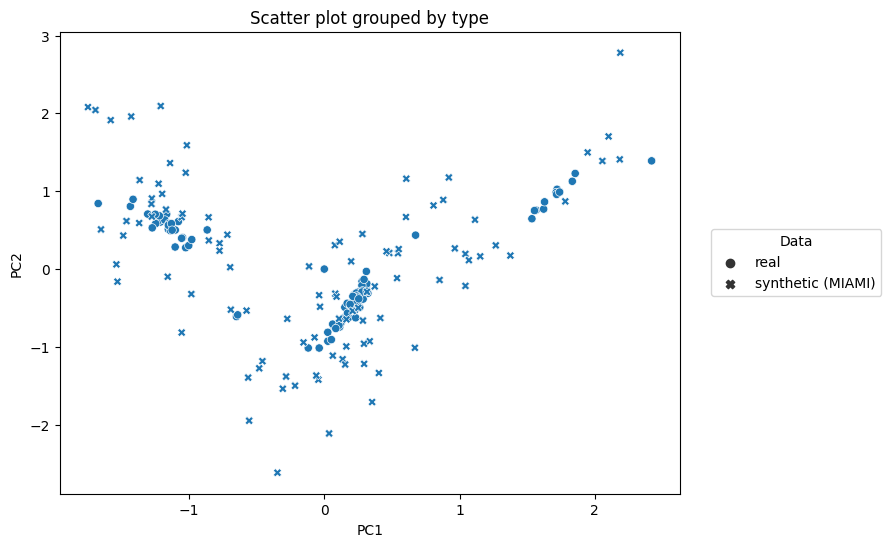

In [15]:
# zz = out["zz"]
# npzz = np.array(zz)
# npzz = np.reshape(npzz, (npzz.shape[0], npzz.shape[-1]))

# mean = np.mean(npzz, axis=0)
# var = np.std(npzz, axis=0)
# var_s = 2


# x_lim = [mean[0] - var_s*var[0], mean[0] + var_s*var[0]]
# y_lim = [mean[1] - var_s*var[1], mean[1] + var_s*var[1]]


def plot_discr(out, train_original, x_lim=[], y_lim=[]):
    df_data = pd.DataFrame()
    df_generated = pd.DataFrame()
    
    df_data["x"] = out['Ez.y'][:,0]
    df_data["y"] = out['Ez.y'][:,1]
    zz = np.concatenate(out['zz'])
    
    df_generated["x"],  df_generated["y"] = zz[:,0], zz[:,1]
    
    df_generated["method"] = "synthetic (MIAMI)"
    
    df_data["method"] = train_original["label"]
    
    df_scatter = pd.concat([df_data, df_generated], axis=0, ignore_index=True)
    

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(data=df_scatter, x="x", y="y", style="method")
    # Add a title and axis labels
    ax.set_title('Scatter plot grouped by type')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Create a legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Data", borderaxespad=0.)
    if len(x_lim)>0:
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])
    plt.show()

plot_discr(out, train_original)
# plot_discr(out, train_original, x_lim=x_lim, y_lim=y_lim)

In [16]:
unique_braces = train_original[brace_cols].to_numpy().flatten()
unique_braces = list(set(unique_braces))
unique_braces.sort()
unique_braces

['K', 'NONE', 'X']

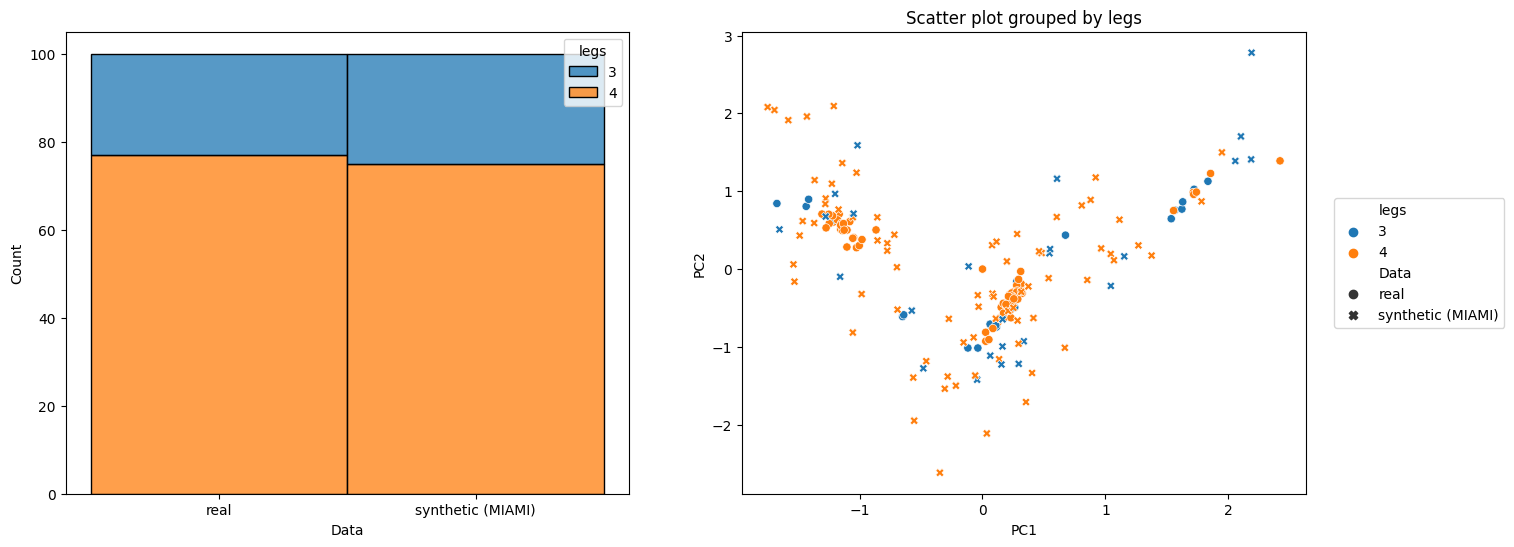

Identified outliers: 5


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


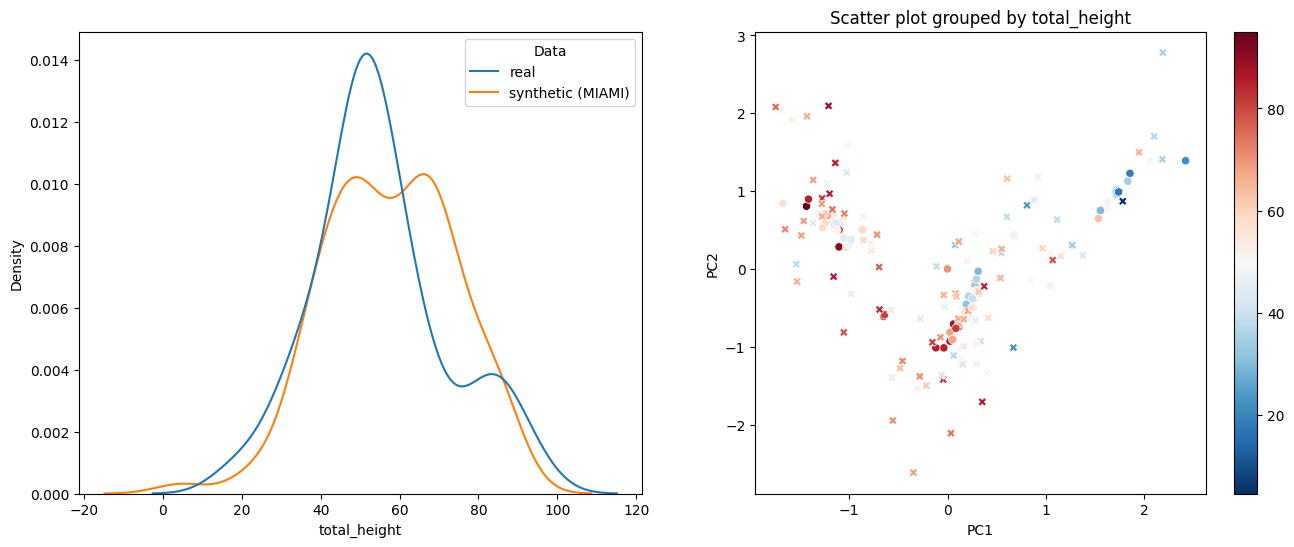

Identified outliers: 7


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


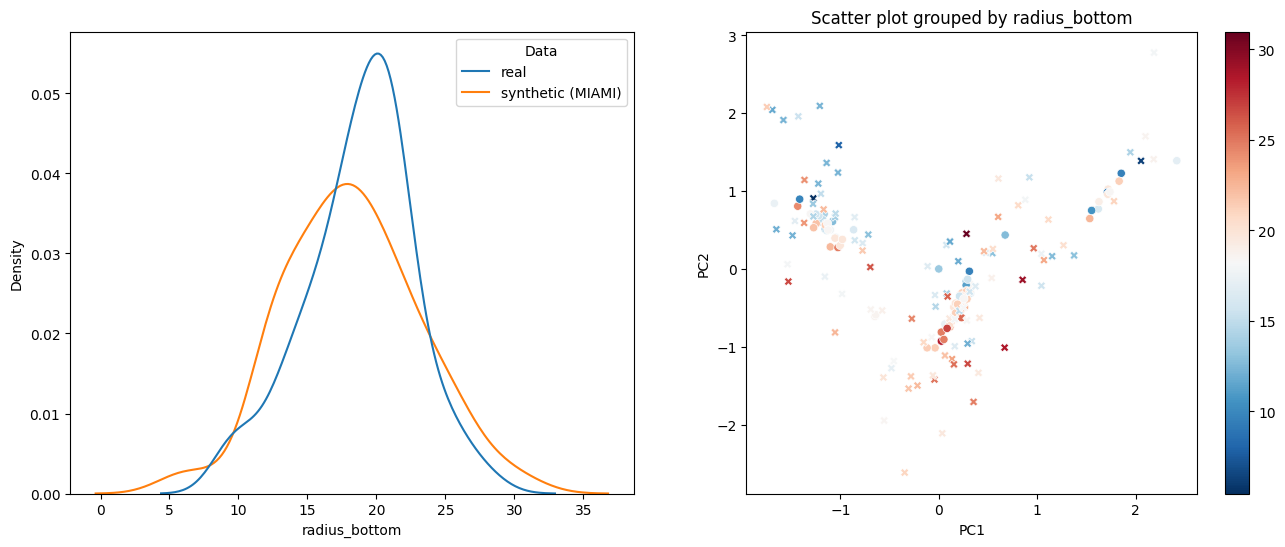

Identified outliers: 6


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


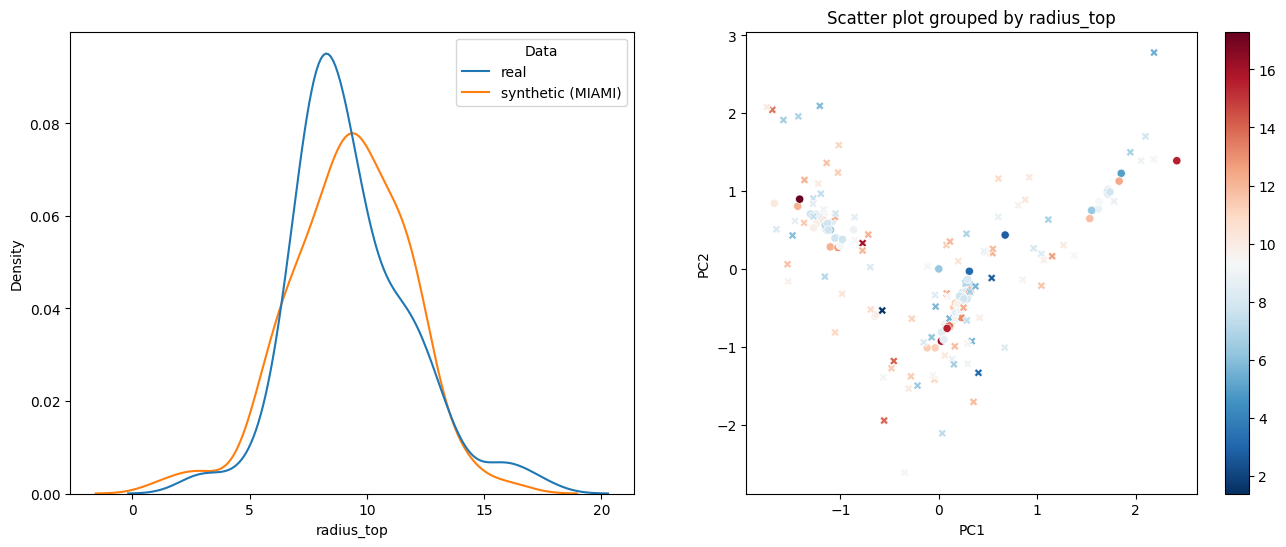

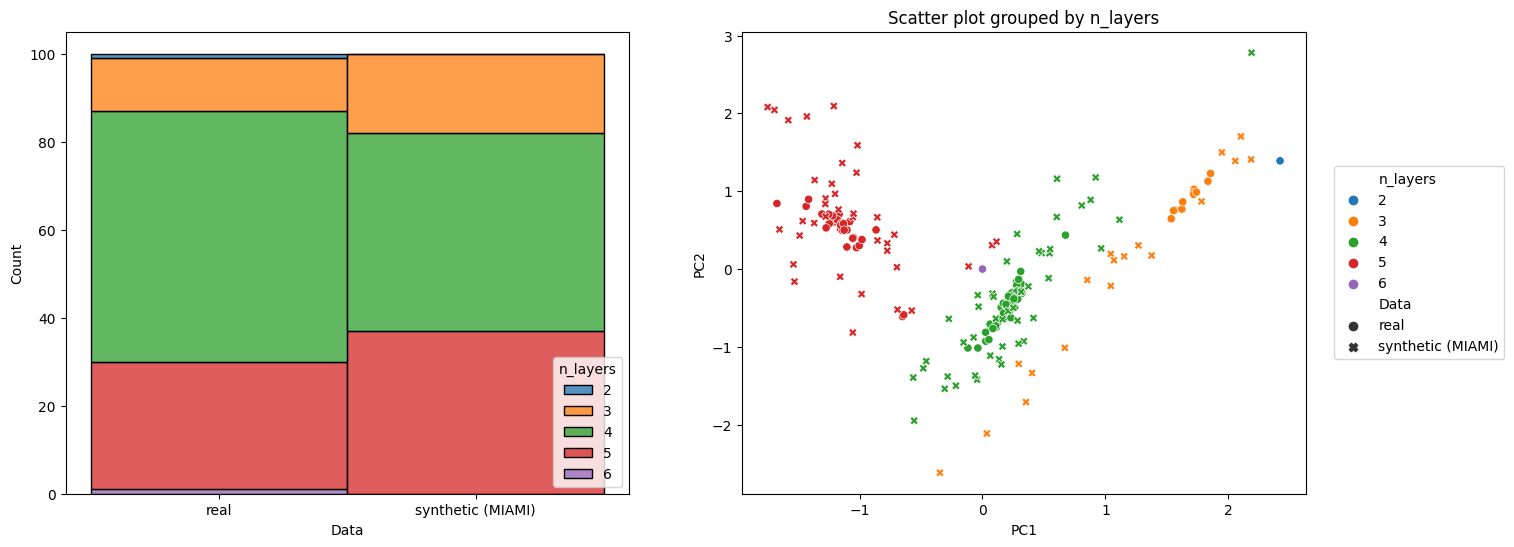

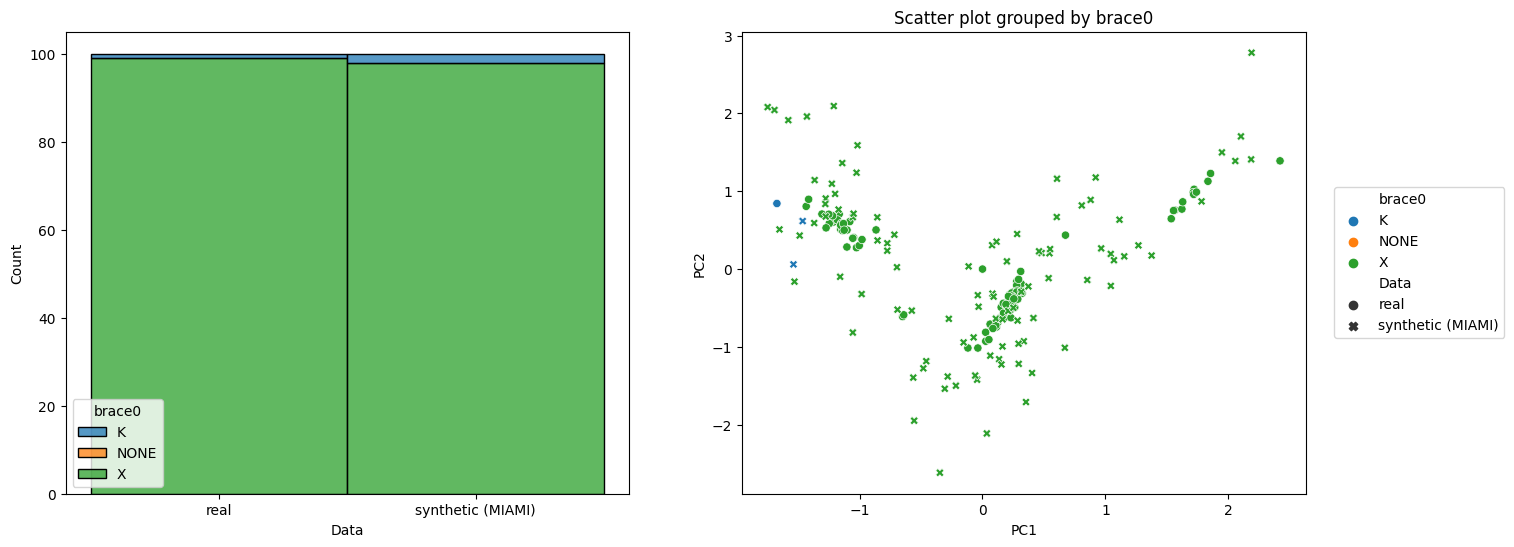

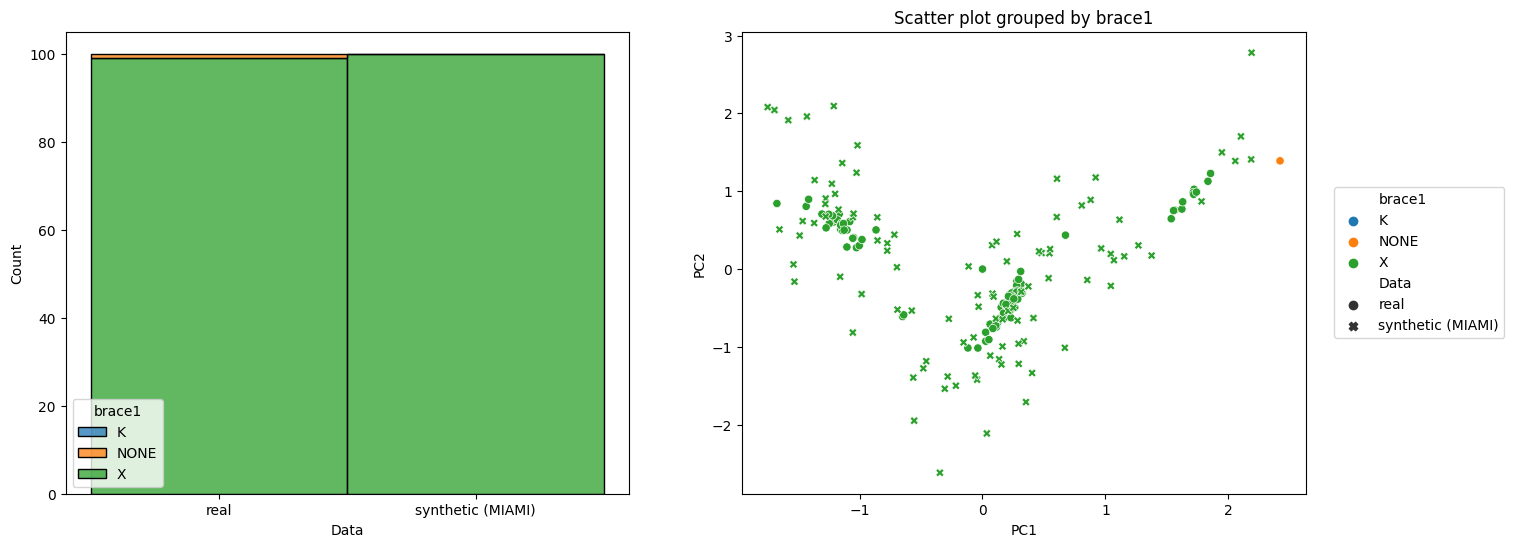

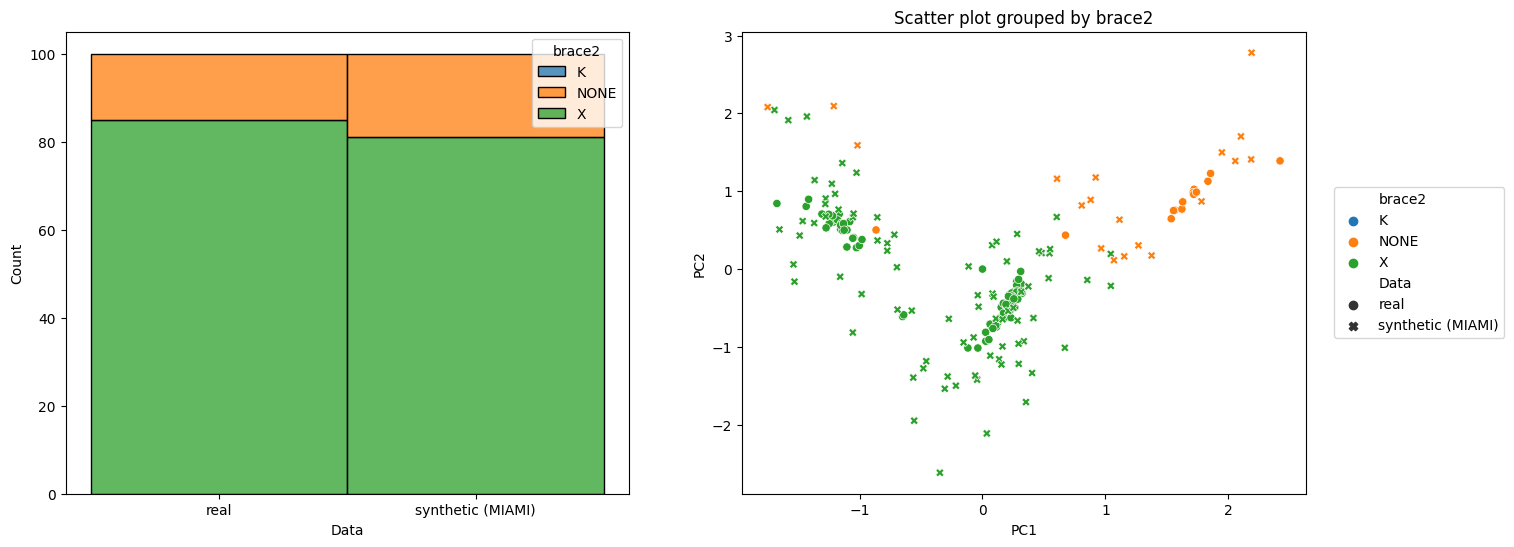

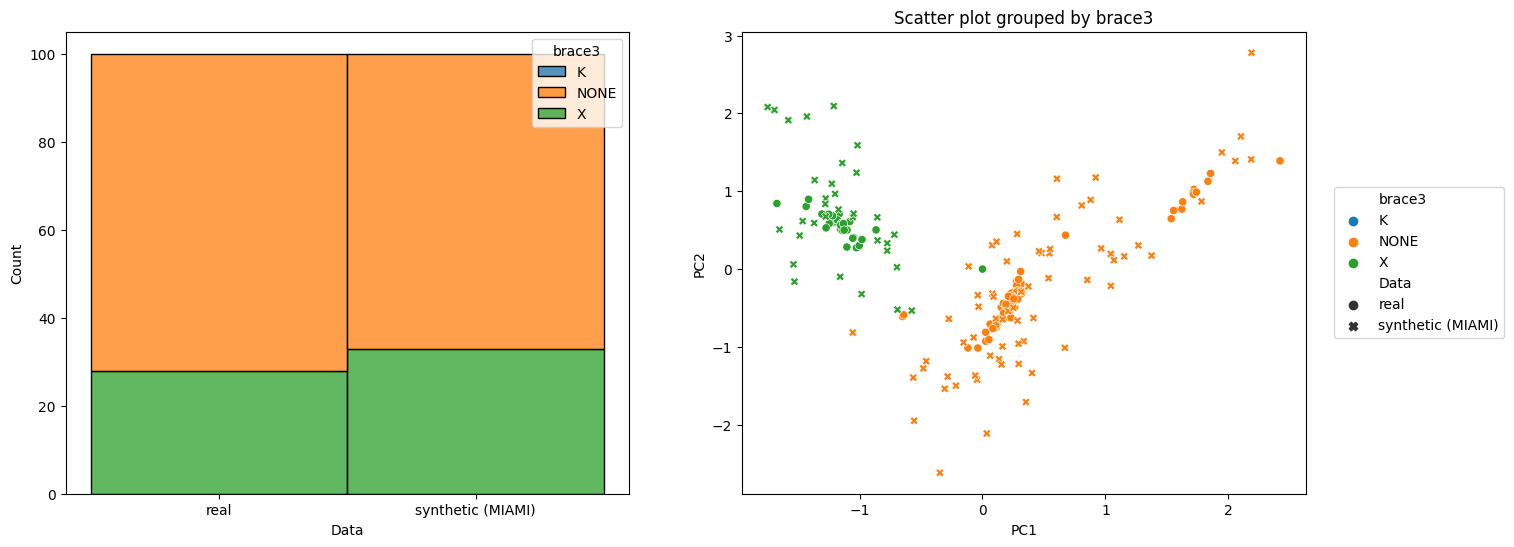

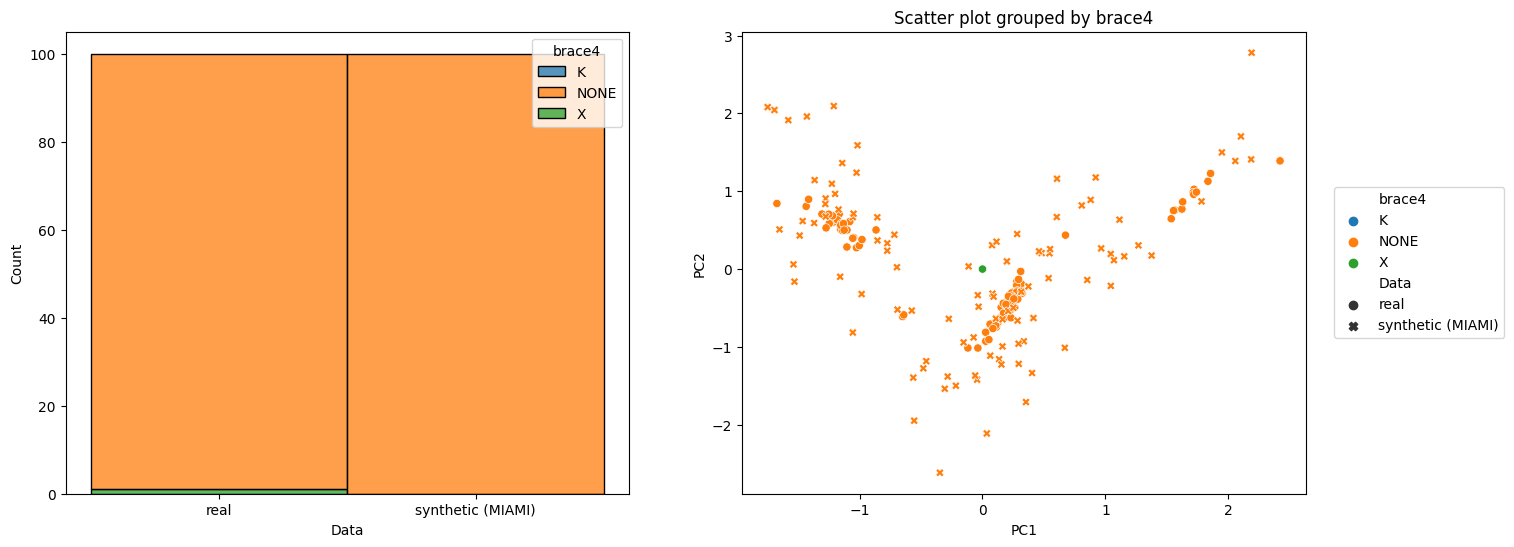

Identified outliers: 3


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


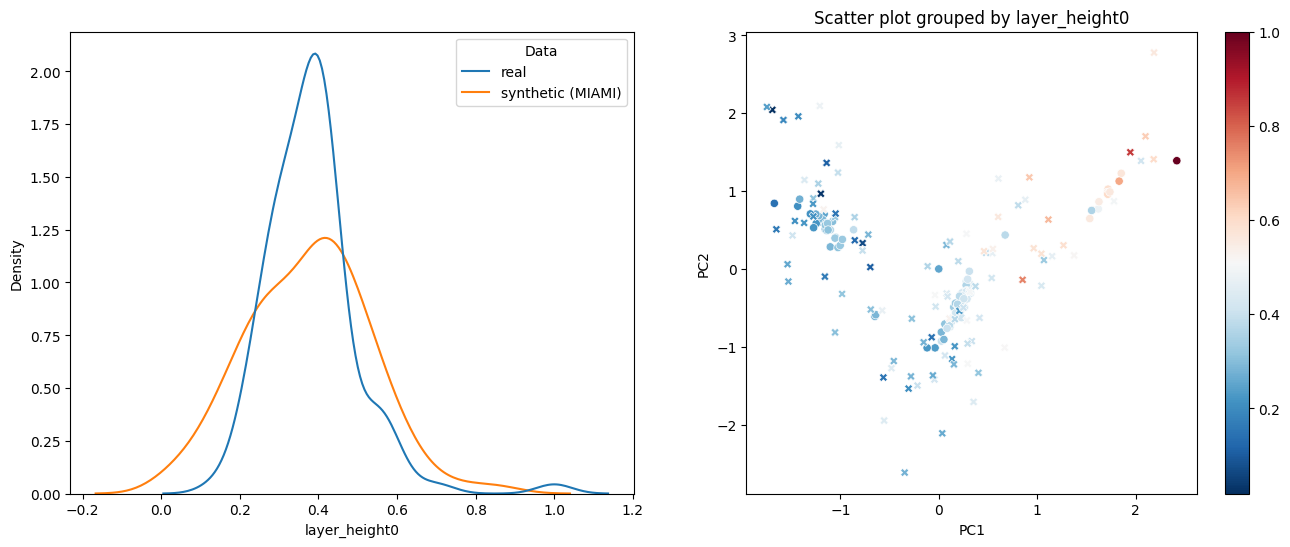

Identified outliers: 0


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


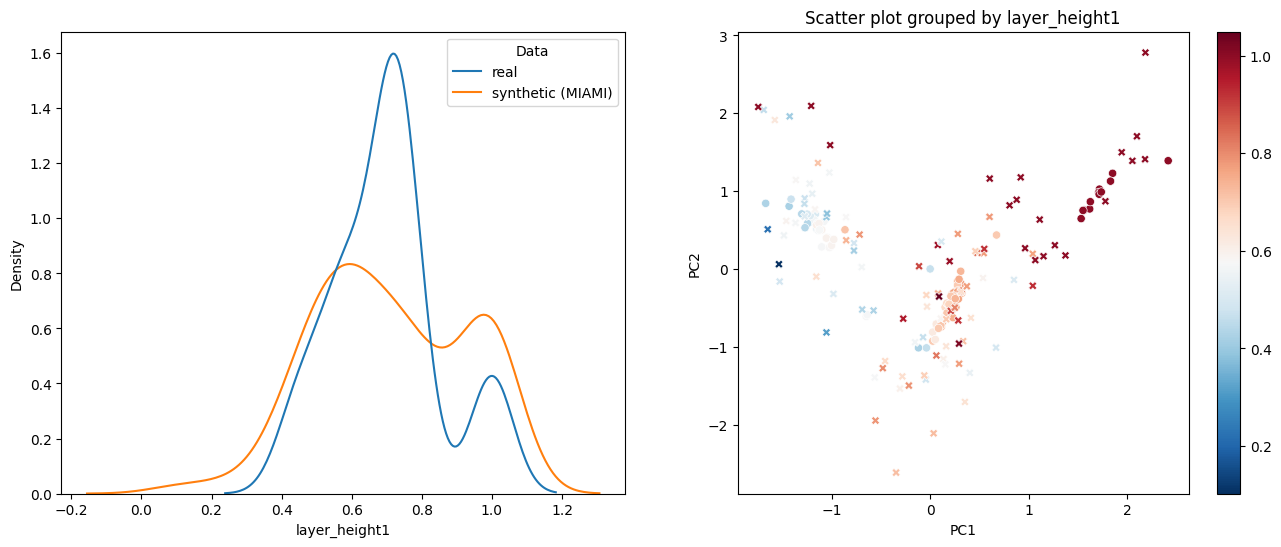

Identified outliers: 8


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)


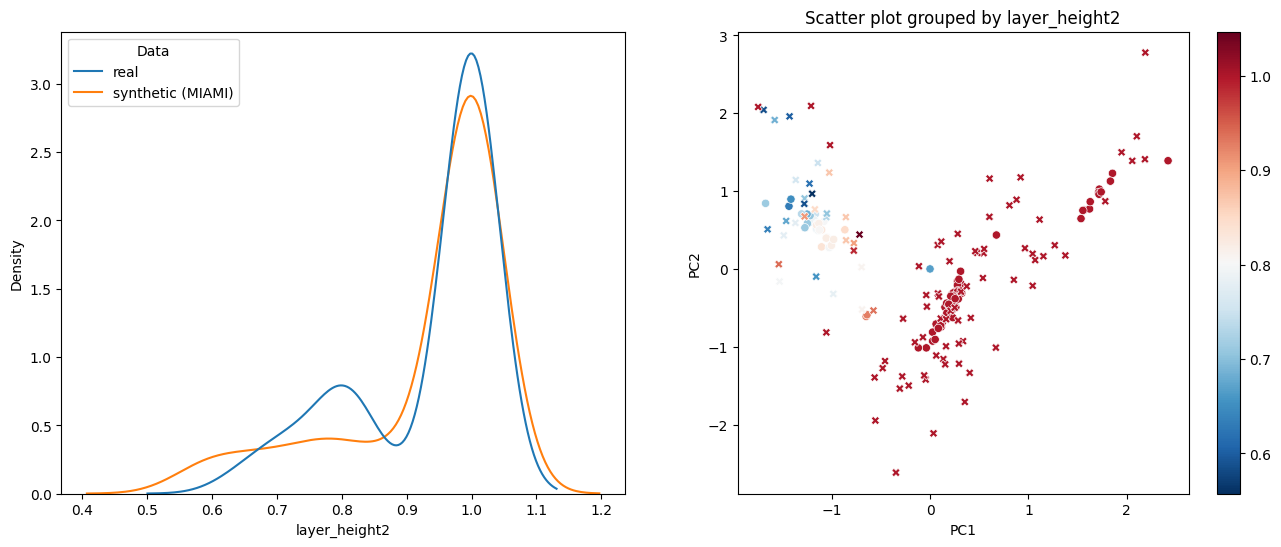

Identified outliers: 1


/tmp/ipykernel_27206/1116826827.py:107: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[1].figure.colorbar(sm)
/tmp/ipykernel_27206/1116826827.py:137: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_scatter, x=colname, hue="Data", ax=ax[0], bw_adjust=1)


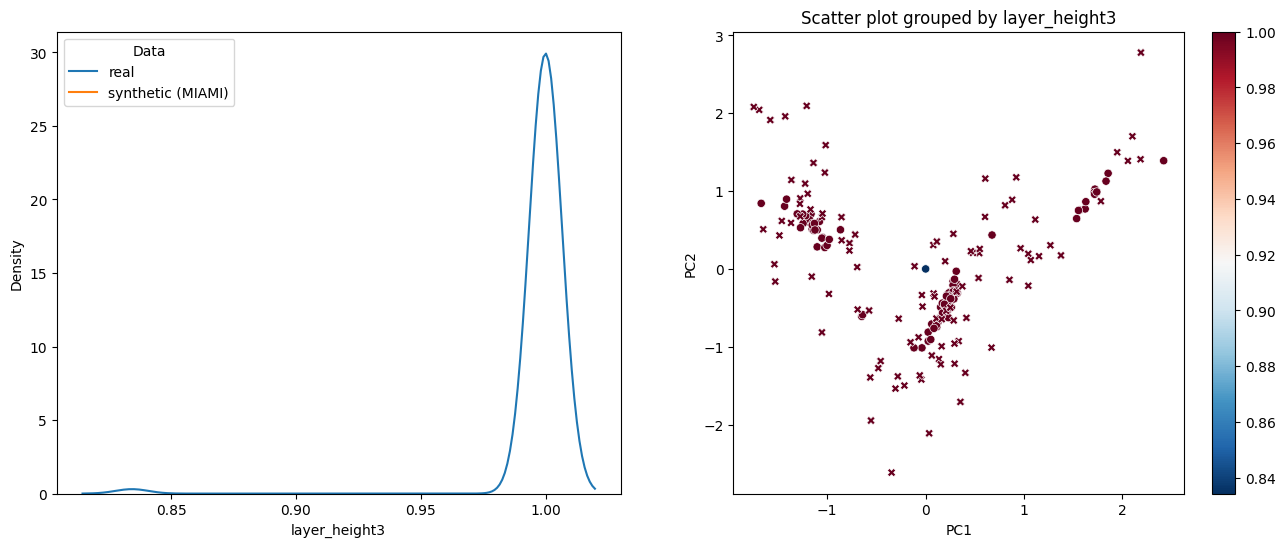

In [137]:
x_lim = []
y_lim = []
s_K=2 # number of variances from mean

df_data = pd.DataFrame()
df_data["x"] = out['Ez.y'][:,0]
df_data["y"] = out['Ez.y'][:,1]

zz = np.concatenate(out['zz'])
df_generated = pd.DataFrame()
df_generated["x"],  df_generated["y"] = zz[:,0], zz[:,1]
    
    
    
    
continuous_position = 0
for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] in ['categorical', 'bernoulli', "ordinal"]: 
    #     feature = "race"
        # le_name_mapping = dict(zip(le_dict[feature].classes_, le_dict[feature].transform(le.classes_)))

        # print(le_name_mapping)
        # labels_real = le_dict[feature].inverse_transform(train_original[feature])
        unique_labels = le_dict[colname].classes_
        le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
        # Compare woman, 60+ y.o and people presenting both modalities
        df_data[colname] = train_original[colname]
        df_data["Data"] = train_original["label"]
        
        df_generated[colname] = pred_post[colname]
        
        df_data[colname] = df_data[colname].astype(str)
        df_generated[colname] = df_generated[colname].astype(str)

        df_generated["Data"] = "synthetic (MIAMI)"
        
        df_scatter = pd.concat([df_data, df_generated], axis=0, ignore_index=True)
        
        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
        
        if colname in brace_cols:
            unique_vals = unique_braces
        else:  
            unique_vals = df_scatter[colname].to_numpy().flatten()
            unique_vals = list(set(unique_vals))
            unique_vals.sort()
            
        sns.scatterplot(data=df_scatter, x="x", y="y", hue=colname, style="Data", hue_order=unique_vals, ax=ax[1])
        # Add a title and axis labels
        ax[1].set_title('Scatter plot grouped by ' + colname)
        ax[1].set_xlabel('PC1')
        ax[1].set_ylabel('PC2')
        if len(x_lim)>0:
            ax[1].set_xlim(x_lim[0], x_lim[1])
            ax[1].set_ylim(y_lim[0], y_lim[1])
        # Create a legend
        legend = ax[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
        
        # Count the occurrences of each number of legs per cluster
        items_per_cluster = df_scatter.groupby(['Data', colname]).size().unstack().fillna(0)
        
        rev_unique_vals = unique_vals
        change_cols_list = [col for col in rev_unique_vals if col in items_per_cluster.columns]
        
        # Reorder the columns based on the sorted labels
        items_per_cluster = items_per_cluster[change_cols_list]
        g = sns.histplot(df_scatter, x='Data', hue=colname, hue_order=unique_vals, multiple='stack', ax=ax[0])
#         g.legend(handles, labels)
#         ax[0].margins(x=0.5)
        ax[0].xaxis.set_tick_params(rotation=0)
        
        plt.show()
    else:
        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
        # calculate summary statistics
        data_mean, data_std = np.mean(train_original[colname]), np.std(train_original[colname])
        # identify outliers
        cut_off = data_std * s_K
        lower, upper = data_mean - cut_off, data_mean + cut_off
        # identify outliers
        outliers = [x for x in train_original[colname] if x < lower or x > upper]
        print('Identified outliers: %d' % len(outliers))
        
         # Compare woman, 60+ y.o and people presenting both modalities
        df_data[colname] = train_original[colname]
        df_data["Data"] = train_original["label"]
        
        df_generated[colname] = pred_post[colname]


        df_generated["Data"] = "synthetic (MIAMI)"
        
        df_scatter = pd.concat([df_data, df_generated], axis=0, ignore_index=True)
        
#         scatter = ax[1].scatter(x=df_scatter['x'], y=df_scatter['y'], c=train_original[colname].astype(int), cmap='RdBu_r', s=10, vmin=lower, vmax=upper)
        scatter = sns.scatterplot(data=df_scatter, x="x", y="y", hue=colname, style="Data", palette="RdBu_r", ax=ax[1])
        
        norm = plt.Normalize(df_scatter[colname].min(), df_scatter[colname].max())
        sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
        sm.set_array([])

        # Remove the legend and add a colorbar
        ax[1].get_legend().remove()
        ax[1].figure.colorbar(sm)
        
        # Add a title and axis labels
        ax[1].set_title('Scatter plot grouped by ' + colname)
        ax[1].set_xlabel('PC1')
        ax[1].set_ylabel('PC2')
#         cb = plt.colorbar(scatter)
#         cb.ax.get_yaxis().labelpad = 15
#         cb.ax.set_ylabel(colname + " range", rotation=270)

#         # add a horizontal line to the colorbar axis
#         cb.ax.hlines(data_mean, 0, 1, color="black")
#         # Add an annotation at the mean value on the left of the colorbar
#         cb.ax.annotate("$\mu$", xy=(cb.ax.get_xlim()[0], data_mean), xytext=(-10, 0),
#                        textcoords="offset points", ha="right", va="center",
#                        fontsize=12, color="black")
#         cb.ax.annotate(r'$\mu + {} \sigma$'.format(s_K), xy=(0, upper), xytext=(0, 10),
#                        textcoords="offset points", ha="center", va="bottom",
#                        fontsize=12, color="black")
#         cb.ax.annotate(r'$\mu - {} \sigma$'.format(s_K), xy=(0, lower), xytext=(0, -10),
#                        textcoords="offset points", ha="center", va="top",
#                        fontsize=12, color="black")
        # Create a legend
#         handles, labels = scatter.legend_elements()
#         legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)
        continuous_position += 1
        if len(x_lim)>0:
            ax[1].set_xlim(x_lim[0], x_lim[1])
            ax[1].set_ylim(y_lim[0], y_lim[1])
            
        sns.kdeplot(data=df_scatter, x=colname, hue="Data", ax=ax[0], bw_adjust=1)
        
        plt.show()